In [1]:
# Repository locations
ATM_DIR = "/epyc/projects/atm/atm/"
ATM_DATA_DIR = "/epyc/projects/atm/atm_data/"

In [2]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=0.8, 
        context="paper", 
        style="ticks", 
        rc={"axes.linewidth": 0.8})
sns.set_palette("viridis")

from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d


%matplotlib inline

import sys
sys.path.append(ATM_DIR)

from atm.obs import WISE
from atm.models import NEATM
from atm.functions import calcM
from atm.functions import calcQ
from atm.functions import calcFluxLambdaAtObsWithSunlight
from atm.analysis import mergeResultsWithNEOWISE
from atm.analysis import calcStdDev
from atm.analysis import _median
from atm.analysis import _sigmaG
from atm.plotting import plotHist

In [3]:
DPI = 300
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = True

In [4]:
SIGMA = 0.15
RUN_DIR = os.path.join(ATM_DATA_DIR, "paper1/runs/sigma{}".format(int(SIGMA * 100)))
RUN_NAME = "run1"

In [5]:
results_database = os.path.join(RUN_DIR, "atm_results_{}.db".format(RUN_NAME))
merged_results, pp_dfs = mergeResultsWithNEOWISE(os.path.join(ATM_DATA_DIR, "paper1/sample.db"),
                                                 results_database, 
                                                 minObs=3, 
                                                 fitCodes=["DVBI"])

There are 165865 fits for 140493 unique objects in the 2016 NEOWISE PDS table.
Selecting only fits with at least 3 observations in each band.
Selecting only fits with fit code(s): DVBI.
There are 3102 fits for 2871 unique objects.
3045 fits have been matched with an object in observations.
Sorting by number of observations and keeping the fits using the most observations...
Merging NEOWISE results with post-processed tables...

2807 fits have been found for 2807 unique objects in observations.
Done.



In [6]:
# Calculate median pseudo absolute magnitudes for each band
mags = merged_results[["mag_W1_median", "mag_W2_median", "mag_W3_median", "mag_W4_median"]].values
D = 10**merged_results["logD_median"].values
delta = merged_results["delta_au_median"].values

M = calcM(mags, D, delta)

for i, M_col in enumerate(["M{}".format(i + 1) for i in range(mags.shape[1])]):
    merged_results[M_col] = M[:, i]

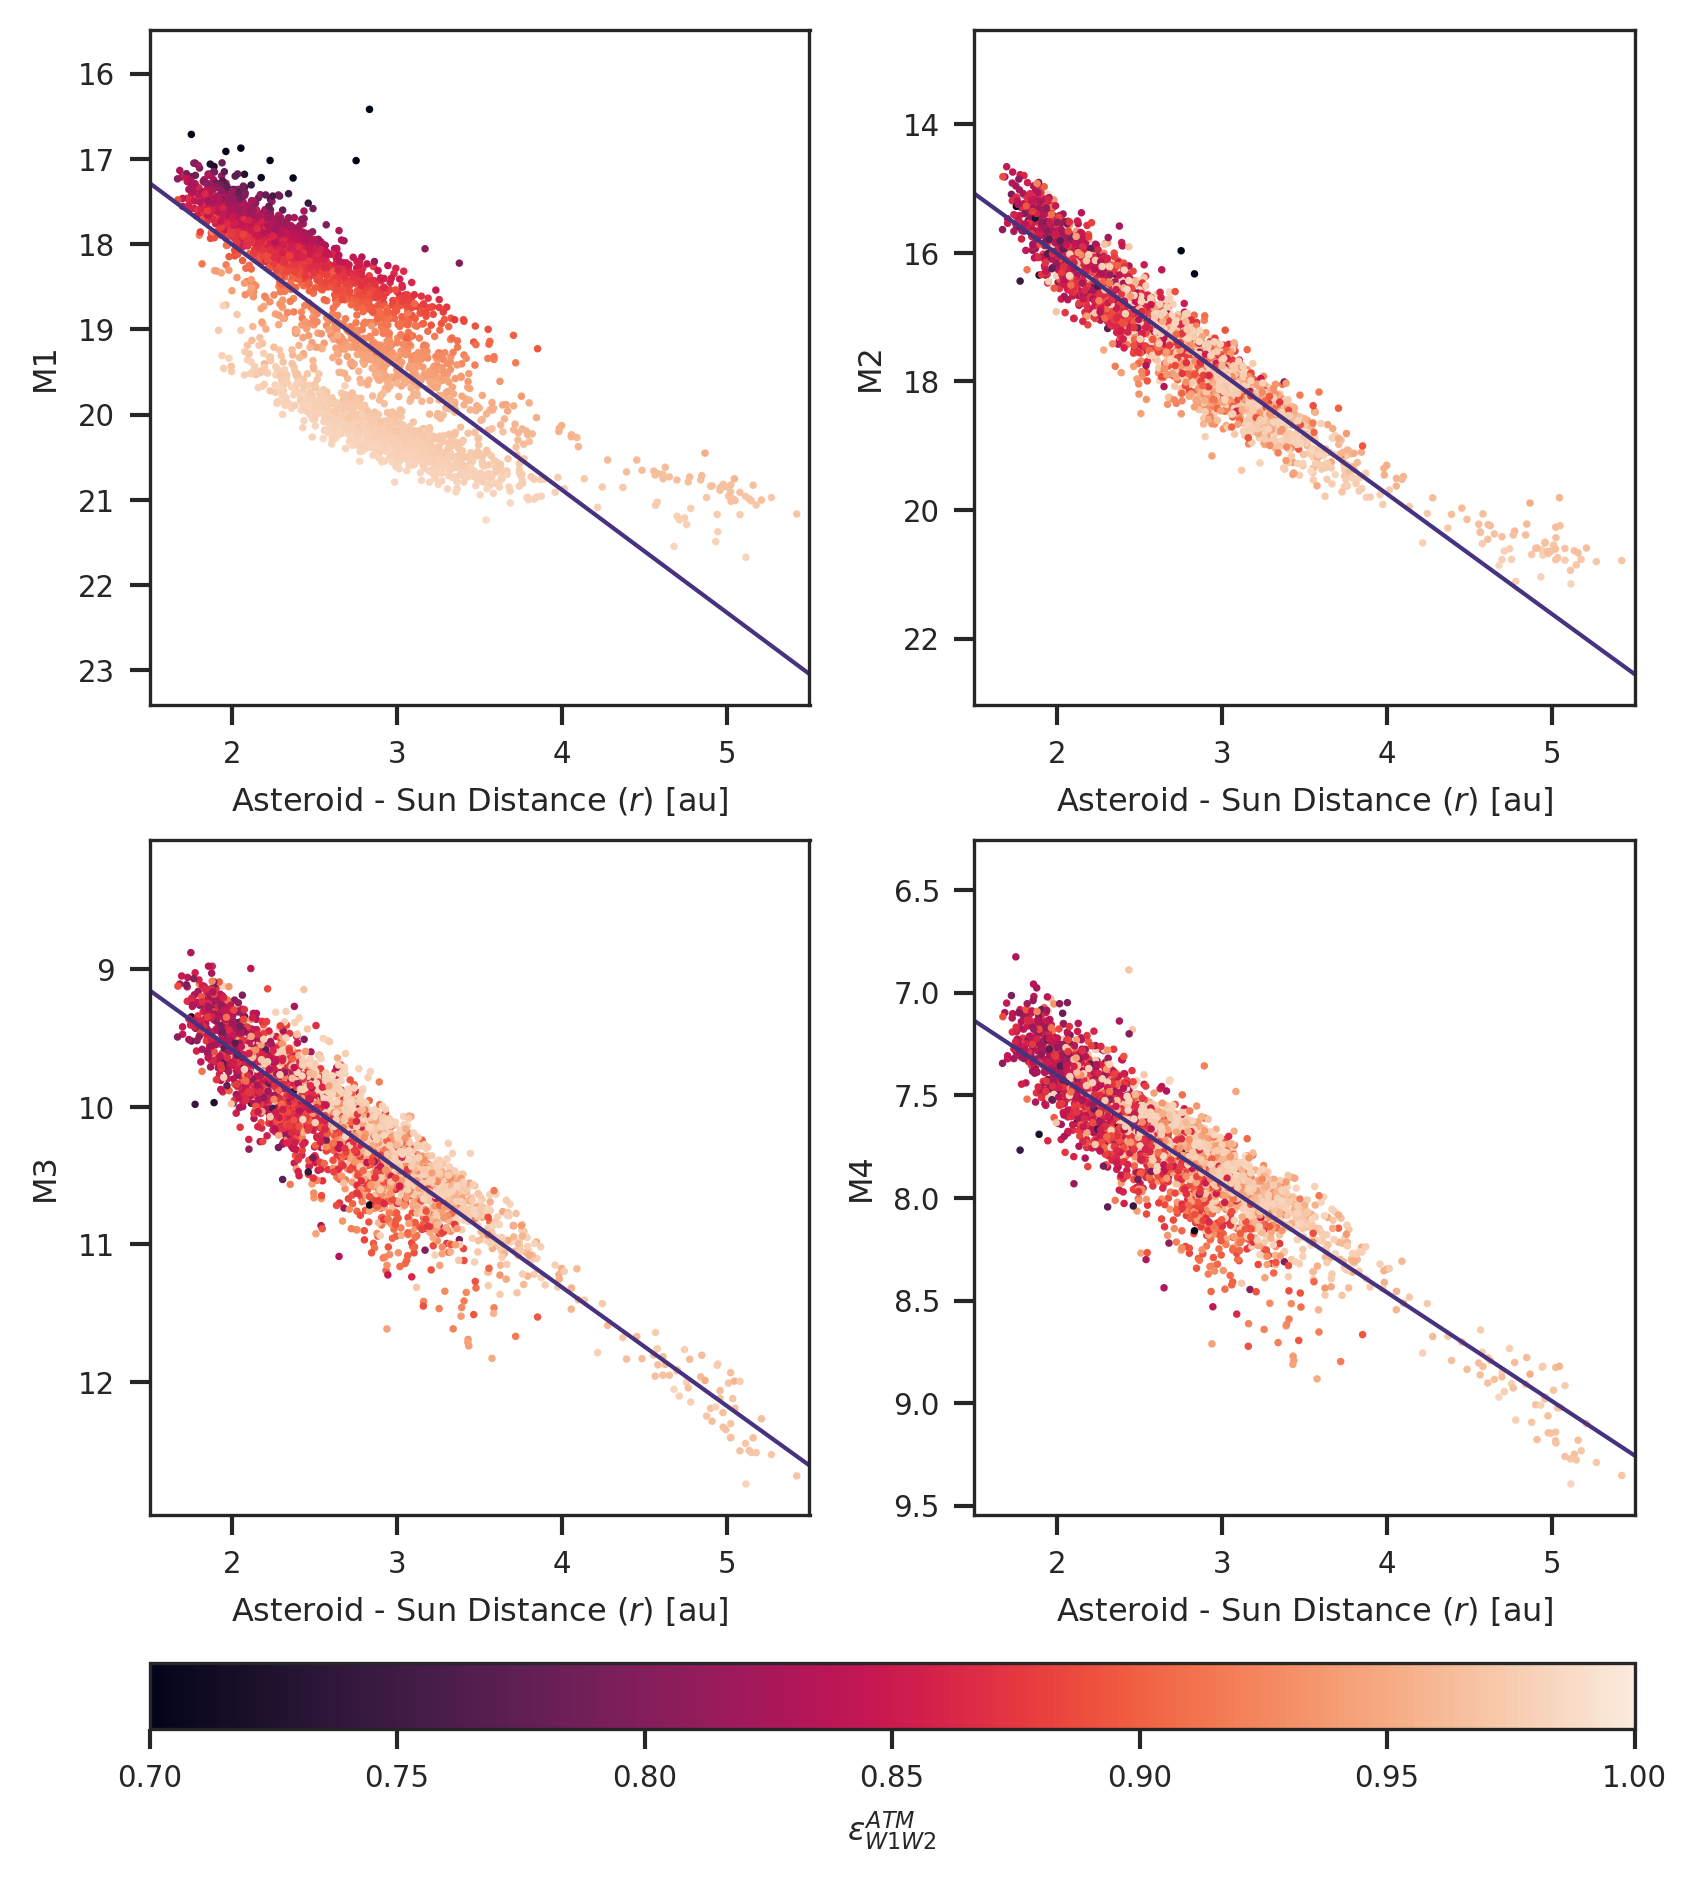

In [7]:
filtered_results = merged_results

scatterKwargs = {
    "s": 1,
    "c" : filtered_results["eps_W1W2_median"].values,
    "vmin": 0.7,
    "vmax" : 1,
}
plotKwargs = {
    "lw" : 1
}
r = np.linspace(1.5, 5.5, 100)

fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   

cm = ax[0, 0].scatter(filtered_results["r_au_median"].values, 
                      filtered_results["M1"].values,
                      **scatterKwargs)
p = np.polyfit(filtered_results["r_au_median"].values, 
               filtered_results["M1"].values, 
               1)
ax[0, 0].plot(r, np.polyval(p, r), **plotKwargs)
ax[0, 0].set_ylabel("M1")

cm = ax[0, 1].scatter(filtered_results["r_au_median"].values, 
                 filtered_results["M2"].values,
                 **scatterKwargs)
p = np.polyfit(filtered_results["r_au_median"].values, 
               filtered_results["M2"].values, 
               1)
ax[0, 1].plot(r, np.polyval(p, r), **plotKwargs)
ax[0, 1].set_ylabel("M2")

cm = ax[1, 0].scatter(filtered_results["r_au_median"].values, 
                 filtered_results["M3"].values,
                 **scatterKwargs)
p = np.polyfit(filtered_results["r_au_median"].values, 
               filtered_results["M3"].values, 
               1)
ax[1, 0].plot(r, np.polyval(p, r), **plotKwargs)
ax[1, 0].set_ylabel("M3")

cm = ax[1, 1].scatter(filtered_results["r_au_median"].values, 
                 filtered_results["M4"].values,
                 **scatterKwargs)
p = np.polyfit(filtered_results["r_au_median"].values, 
               filtered_results["M4"].values, 
               1)
ax[1, 1].plot(r, np.polyval(p, r), **plotKwargs)
ax[1, 1].set_ylabel("M4")

cbar_ax = fig.add_axes([0.05, -0.08, 0.90, 0.04])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"$\epsilon^{ATM}_{W1W2}$", 
             orientation="horizontal")

for i in range(2):
    for j in range(2):
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlabel("Asteroid - Sun Distance ($r$) [au]")
        ax[i,j].set_xlim(1.5, 5.5)

In [8]:
p1 = np.polyfit(filtered_results["r_au_median"].values, 
                filtered_results["M1"].values, 
                1)
print(p1)

p2 = np.polyfit(filtered_results["r_au_median"].values, 
                filtered_results["M2"].values, 
                1)
print(p2)

p3 = np.polyfit(filtered_results["r_au_median"].values, 
                filtered_results["M3"].values, 
                1)
print(p3)

p4 = np.polyfit(filtered_results["r_au_median"].values, 
                filtered_results["M4"].values, 
                1)
print(p4)

[ 1.44062827 15.12139547]
[ 1.8678873  12.27847426]
[0.8630008  7.85890506]
[0.52948588 6.34293272]


In [9]:
def estimateLogD(mag, r, delta, fits):
    D = np.zeros_like(mag)
    
    for i, p in enumerate(fits):
        D[:, i] = 3 + (p[1] + p[0] * r + 5 * np.log10(delta) - mag[:,i]) / 5
        
    return D 

In [10]:
logD_est = estimateLogD(merged_results[["mag_W1_median", "mag_W2_median", "mag_W3_median", "mag_W4_median"]].values,
                        merged_results["r_au_median"].values,
                        merged_results["delta_au_median"].values,
                        [p1, p2, p3, p4])

merged_results["logD_approx_W1"] = logD_est[:, 0]
merged_results["logD_approx_W2"] = logD_est[:, 1]
merged_results["logD_approx_W3"] = logD_est[:, 2]
merged_results["logD_approx_W4"] = logD_est[:, 3]

35 values are outside the defined minimum and maximum.
9 values are outside the defined minimum and maximum.
0 values are outside the defined minimum and maximum.
0 values are outside the defined minimum and maximum.


/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(x

Text(0.3, 5.6000000000000005, '$\\sigma_G$: 0.063')

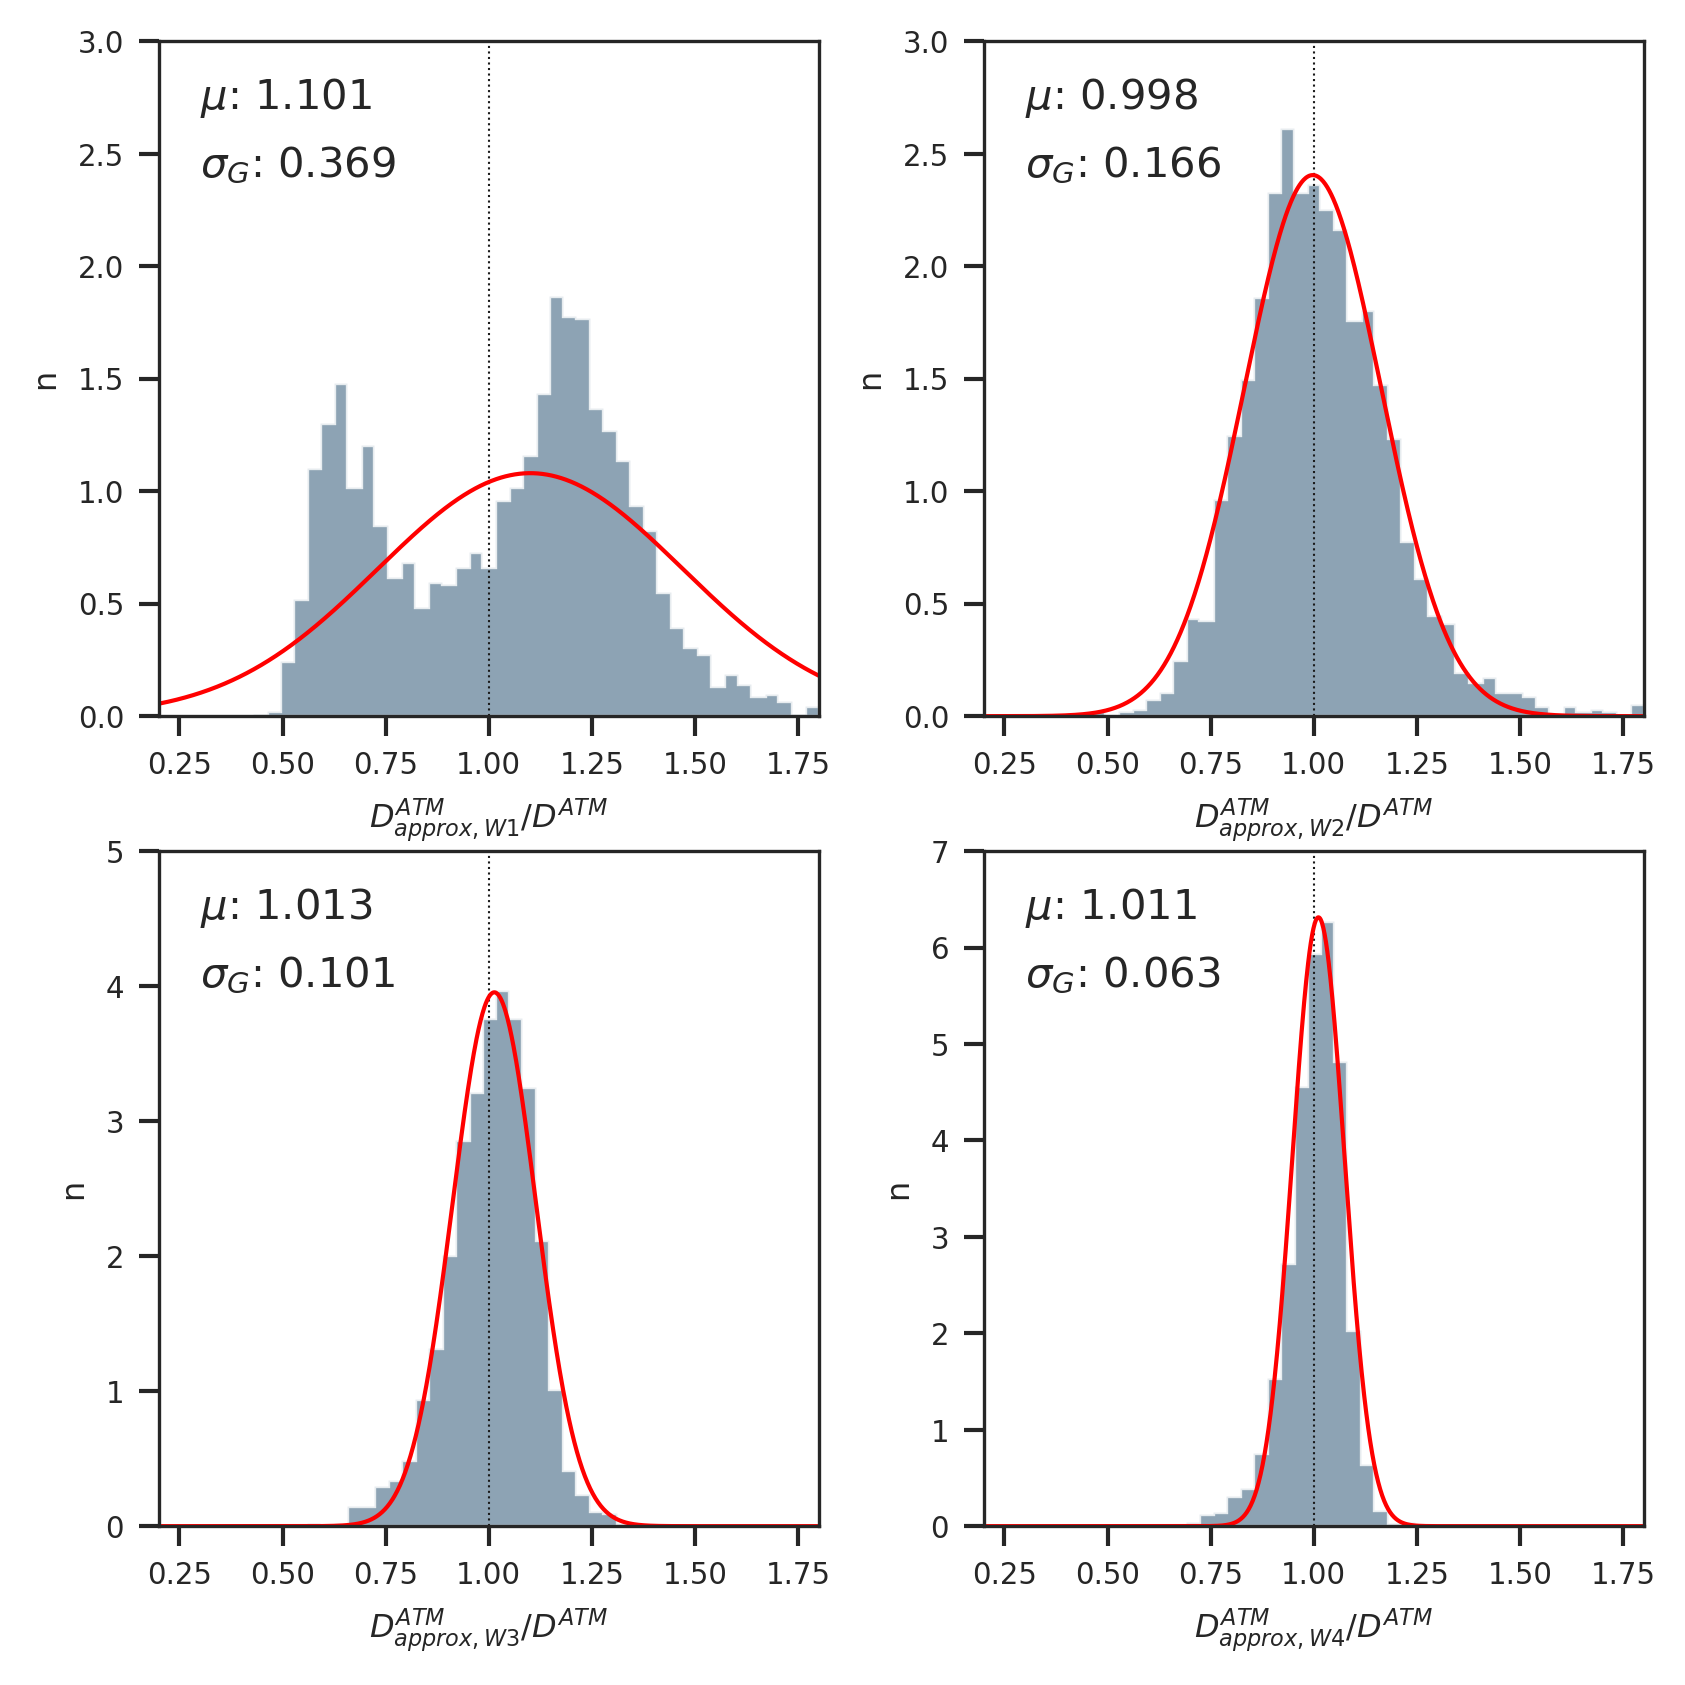

In [11]:
filtered_results = merged_results

histKwargs = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.8, 
    "normed" : True,
}
plotKwargs = {
    "ls" : "-",
    "lw" : 1,
    "c" : "red"
}

plotKwargsComponents = {
    "ls" : ":",
    "lw" : 1,
    "c" : "red",
    "alpha" : 0.8
}

verticalLines = {
    "lw" : 0.5,
    "linestyle" : ":",
}


fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   

ax[0,0], stats = plotHist(ax[0,0], 
                          10**filtered_results["logD_approx_W1"].values / 10**filtered_results["logD_median"].values, 
                          [0.2, 1.8], 
                          numGauss=1, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs)
ax[0,0].vlines([1.0], 0, 3, **verticalLines)
ax[0,0].set_ylabel("n")
ax[0,0].set_xlabel(r"$D_{approx, W1}^{ATM} / D^{ATM}$")
ax[0,0].set_xlim(0.2, 1.8)
ax[0,0].set_ylim(0, 3)
ax[0,0].text(0.3, 0.9*3, r"$\mu$: {:.3f}".format(stats[0]))
ax[0,0].text(0.3, 0.8*3, r"$\sigma_G$: {:.3f}".format(stats[1]))

ax[0,1], stats = plotHist(ax[0,1], 
                          10**filtered_results["logD_approx_W2"].values / 10**filtered_results["logD_median"].values, 
                          [0.2, 1.8], 
                          numGauss=1, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs)
ax[0,1].vlines([1.0], 0, 3, **verticalLines)
ax[0,1].set_xlabel(r"$D_{approx, W2}^{ATM} / D^{ATM}$")
ax[0,1].set_ylabel("n")
ax[0,1].set_xlim(0.2, 1.8)
ax[0,1].set_ylim(0, 3)
ax[0,1].text(0.3, 0.9*3, r"$\mu$: {:.3f}".format(stats[0]))
ax[0,1].text(0.3, 0.8*3, r"$\sigma_G$: {:.3f}".format(stats[1]))

ax[1,0], stats = plotHist(ax[1,0], 
                          10**filtered_results["logD_approx_W3"].values / 10**filtered_results["logD_median"].values, 
                          [0.2, 1.8], 
                          numGauss=1, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs)
ax[1,0].set_ylabel("n")
ax[1,0].vlines([1.0], 0, 5, **verticalLines)
ax[1,0].set_xlabel(r"$D_{approx, W3}^{ATM} / D^{ATM}$")
ax[1,0].set_xlim(0.2, 1.8)
ax[1,0].set_ylim(0, 5)
ax[1,0].text(0.3, 0.9*5, r"$\mu$: {:.3f}".format(stats[0]))
ax[1,0].text(0.3, 0.8*5, r"$\sigma_G$: {:.3f}".format(stats[1]))


ax[1,1], stats = plotHist(ax[1,1], 
                          10**filtered_results["logD_approx_W4"].values  / 10**filtered_results["logD_median"].values, 
                          [0.2, 1.8], 
                          numGauss=1, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs)
ax[1,1].set_ylabel("n")
ax[1,1].vlines([1.0], 0, 7, **verticalLines)
ax[1,1].set_xlabel(r"$D_{approx, W4}^{ATM} / D^{ATM}$")
ax[1,1].set_xlim(0.2, 1.8)
ax[1,1].set_ylim(0, 7)
ax[1,1].text(0.3, 0.9*7, r"$\mu$: {:.3f}".format(stats[0]))
ax[1,1].text(0.3, 0.8*7, r"$\sigma_G$: {:.3f}".format(stats[1]))

Filtered results: 2707


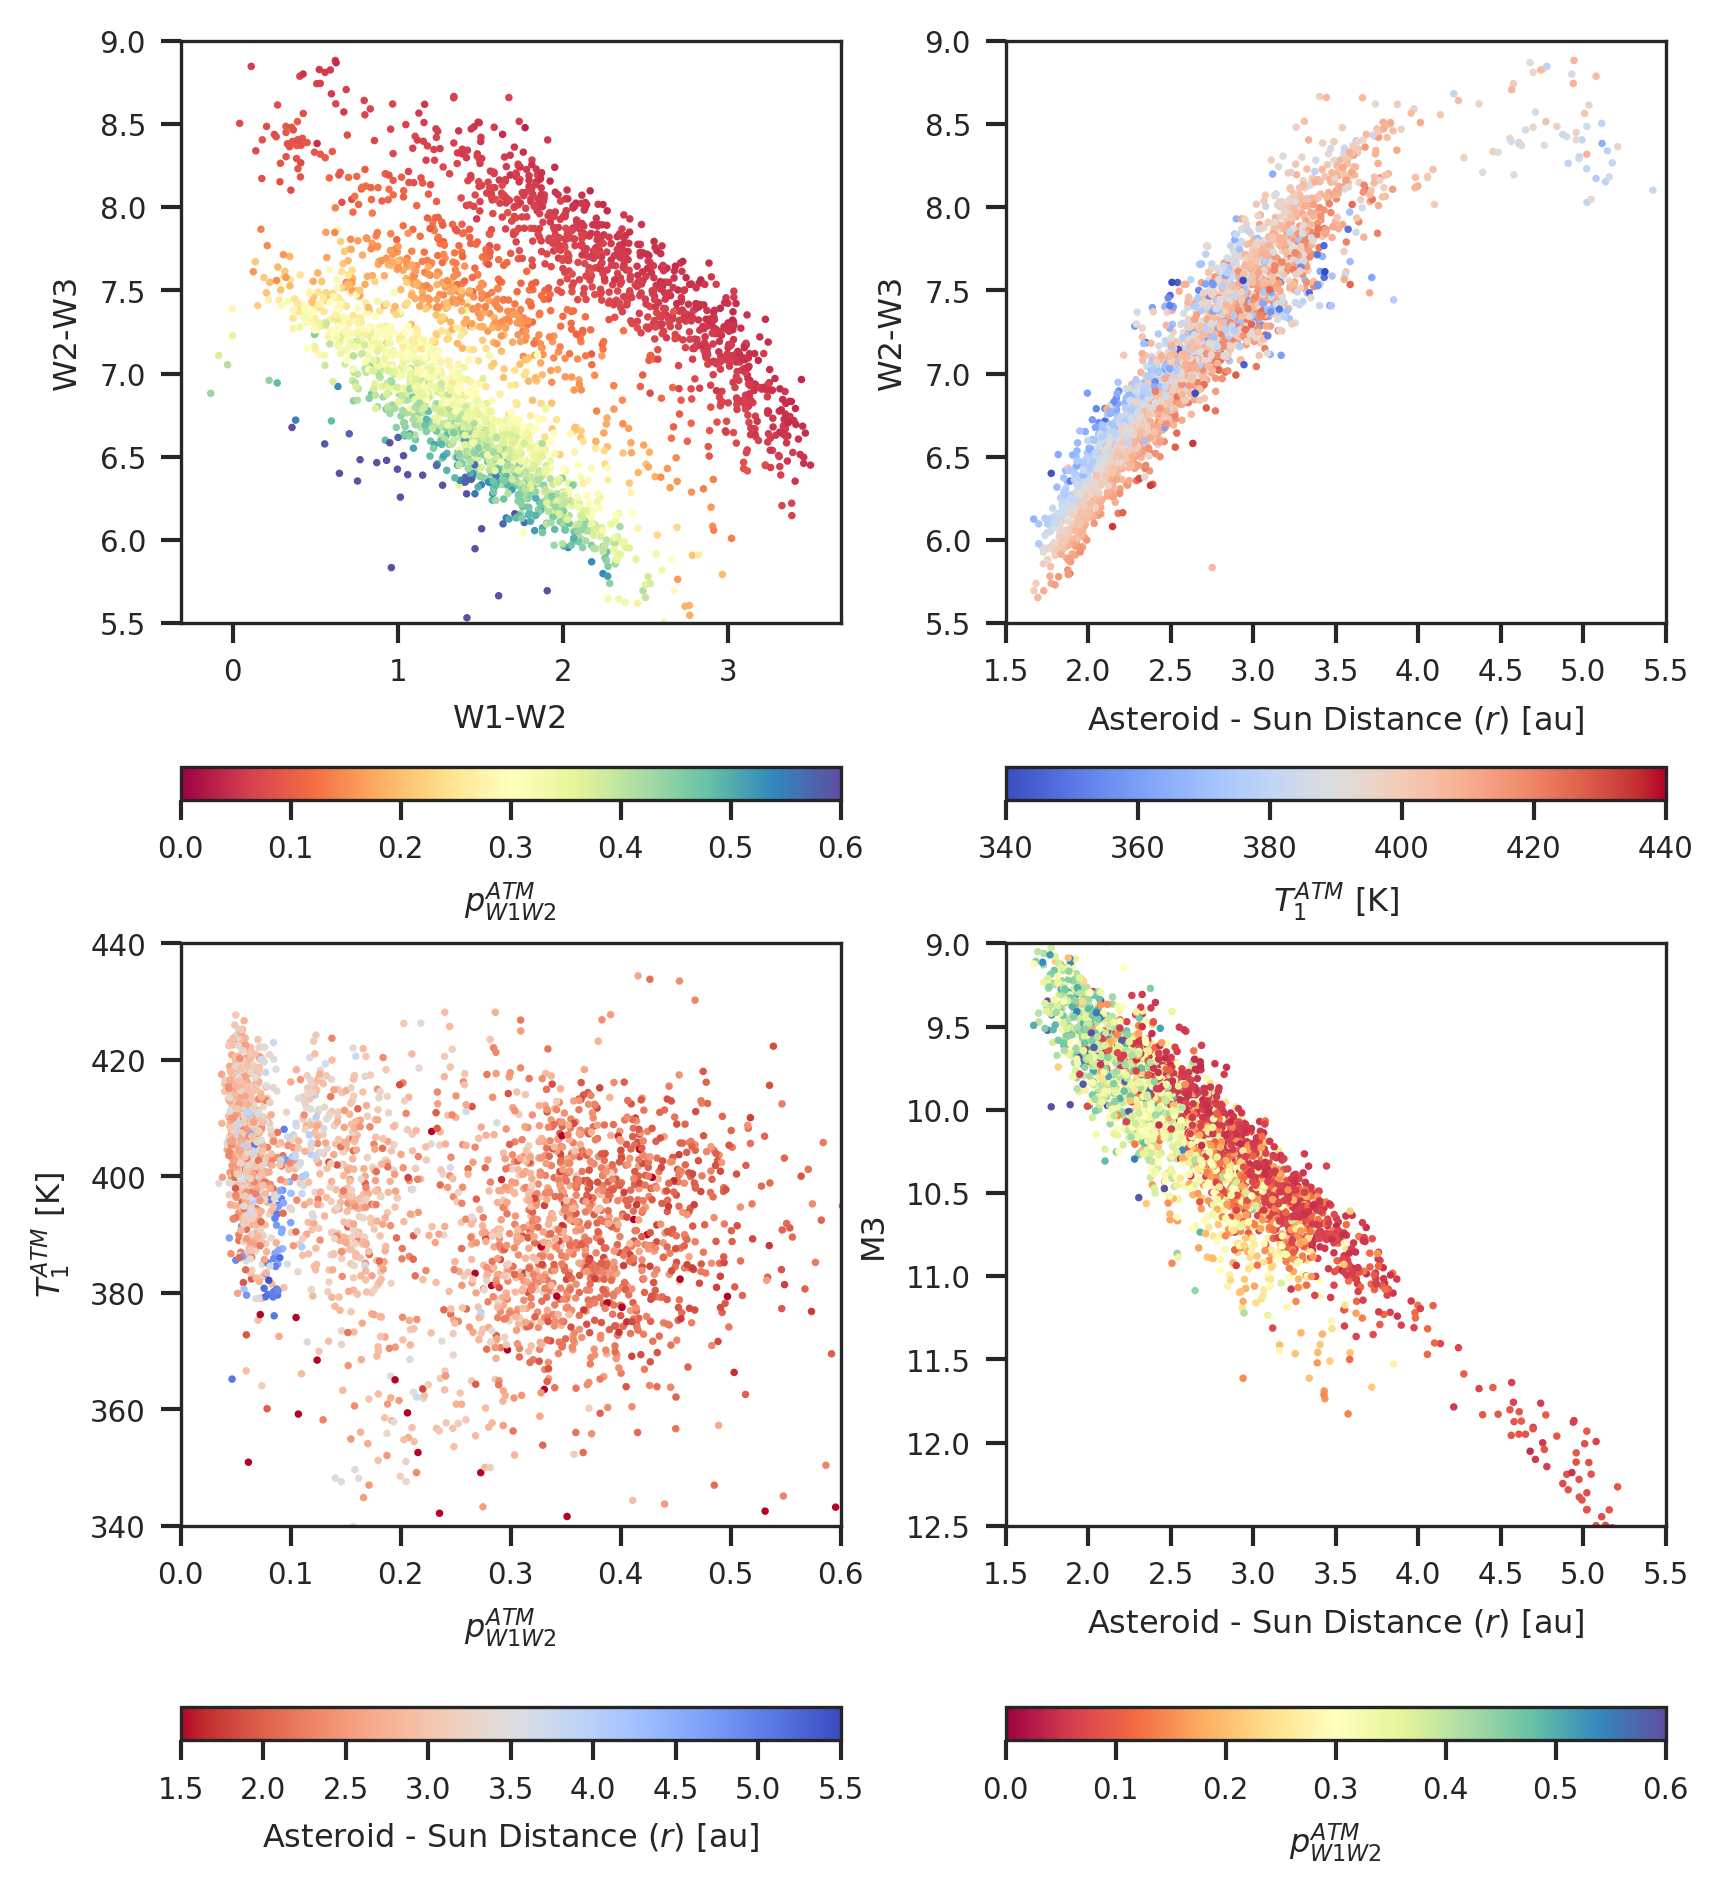

In [12]:
merged_results["eps_W1W2_NEOWISE"] = 1 - merged_results["IR_ALBEDO"] * calcQ(merged_results["SLOPE_PARAM"])
merged_results["p_W1W2_median"] = (1 - merged_results["eps_W1W2_median"]) / calcQ(merged_results["G_median"])

filtered_results = merged_results[(merged_results["num_W1"] >= 4)
                                  & (merged_results["num_W2"] >= 4)
                                  & (merged_results["num_W3"] >= 4)
                                  & (merged_results["num_W4"] >= 4)
                                  & (merged_results["reduced_chi2"] < 3)]
print("Filtered results: {}".format(len(filtered_results)))

scatterKwargs = {
    "s": 1,
}

fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.55)   
cbar_ax = fig.add_axes([0.05, 0.49, 0.40, 0.02])
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('top')
cm = ax[0,0].scatter(filtered_results["W1-W2_median"].values, 
                     filtered_results["W2-W3_median"].values,
                     c=filtered_results["p_W1W2_median"].values,
                     cmap="Spectral",
                     vmin=0, 
                     vmax=0.6,
                     **scatterKwargs)
ax[0,0].set_xlabel("W1-W2")
ax[0,0].set_ylabel("W2-W3")
ax[0,0].set_ylim(5.5, 9.0)
cb = fig.colorbar(cm, 
             cax=cbar_ax,
             label=r"$p^{ATM}_{W1W2}$", 
             orientation="horizontal")


cbar_ax = fig.add_axes([0.55, 0.49, 0.40, 0.02])
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('top')
cm = ax[0,1].scatter(filtered_results["r_au_median"].values, 
                     filtered_results["W2-W3_median"].values,
                     c=10**filtered_results["logT1_median"].values,
                     vmin=340,
                     vmax=440,
                     cmap="coolwarm",
                     **scatterKwargs)
ax[0,1].set_xlabel(r"Asteroid - Sun Distance ($r$) [au]")
ax[0,1].set_ylabel("W2-W3")
ax[0,1].set_xlim(1.5, 5.5)
ax[0,1].set_ylim(5.5, 9.0)
ax[0,1].set_xticks(np.arange(1.5, 6.0, 0.5))
fig.colorbar(cm, 
             cax=cbar_ax,
             label=r"$T_1^{ATM}$ [K]", 
             orientation="horizontal")

cbar_ax = fig.add_axes([0.05, -0.08, 0.40, 0.02])
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('top')
cm = ax[1,0].scatter(filtered_results["p_W1W2_median"].values, 
                     10**filtered_results["logT1_median"].values, 
                     c=filtered_results["r_au_median"].values,
                     cmap="coolwarm_r",
                     vmin=1.5,
                     vmax=5.5,
                     **scatterKwargs)
ax[1,0].set_xlabel("$p^{ATM}_{W1W2}$")
ax[1,0].set_ylabel("$T_1^{ATM}$ [K]")
ax[1,0].set_xlim(0, 0.6)
ax[1,0].set_ylim(340, 440)
fig.colorbar(cm, 
             cax=cbar_ax,
             label=r"Asteroid - Sun Distance ($r$) [au]", 
             orientation="horizontal",
             ticks=np.arange(1.5, 6.0, 0.5))

cbar_ax = fig.add_axes([0.55, -0.08, 0.40, 0.02])
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('top')
cm = ax[1,1].scatter(filtered_results["r_au_median"].values, 
                     filtered_results["M3"].values, 
                     c=filtered_results["p_W1W2_median"].values,
                     cmap="Spectral",
                     vmin=0.0,
                     vmax=0.6,
                     **scatterKwargs)
ax[1,1].set_xlabel(r"Asteroid - Sun Distance ($r$) [au]")
ax[1,1].set_ylabel("M3")
ax[1,1].set_xlim(1.5, 5.5)
ax[1,1].set_ylim(9.0, 12.5)
ax[1,1].set_xticks(np.arange(1.5, 6.0, 0.5))
ax[1,1].invert_yaxis()
fig.colorbar(cm, 
             cax=cbar_ax,
             label=r"$p^{ATM}_{W1W2}$", 
             orientation="horizontal")

if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "M3_color_albedo.{}".format(FORMAT)),
            bbox_inches='tight')

Filtered results: 2707
17 values are outside the defined minimum and maximum.
2 values are outside the defined minimum and maximum.


/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)
/epyc/projects/atm/atm/atm/plotting/histograms.py:46: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(xValues, bins=np.linspace(xRange[0], xRange[1], bins), **histKwargs)


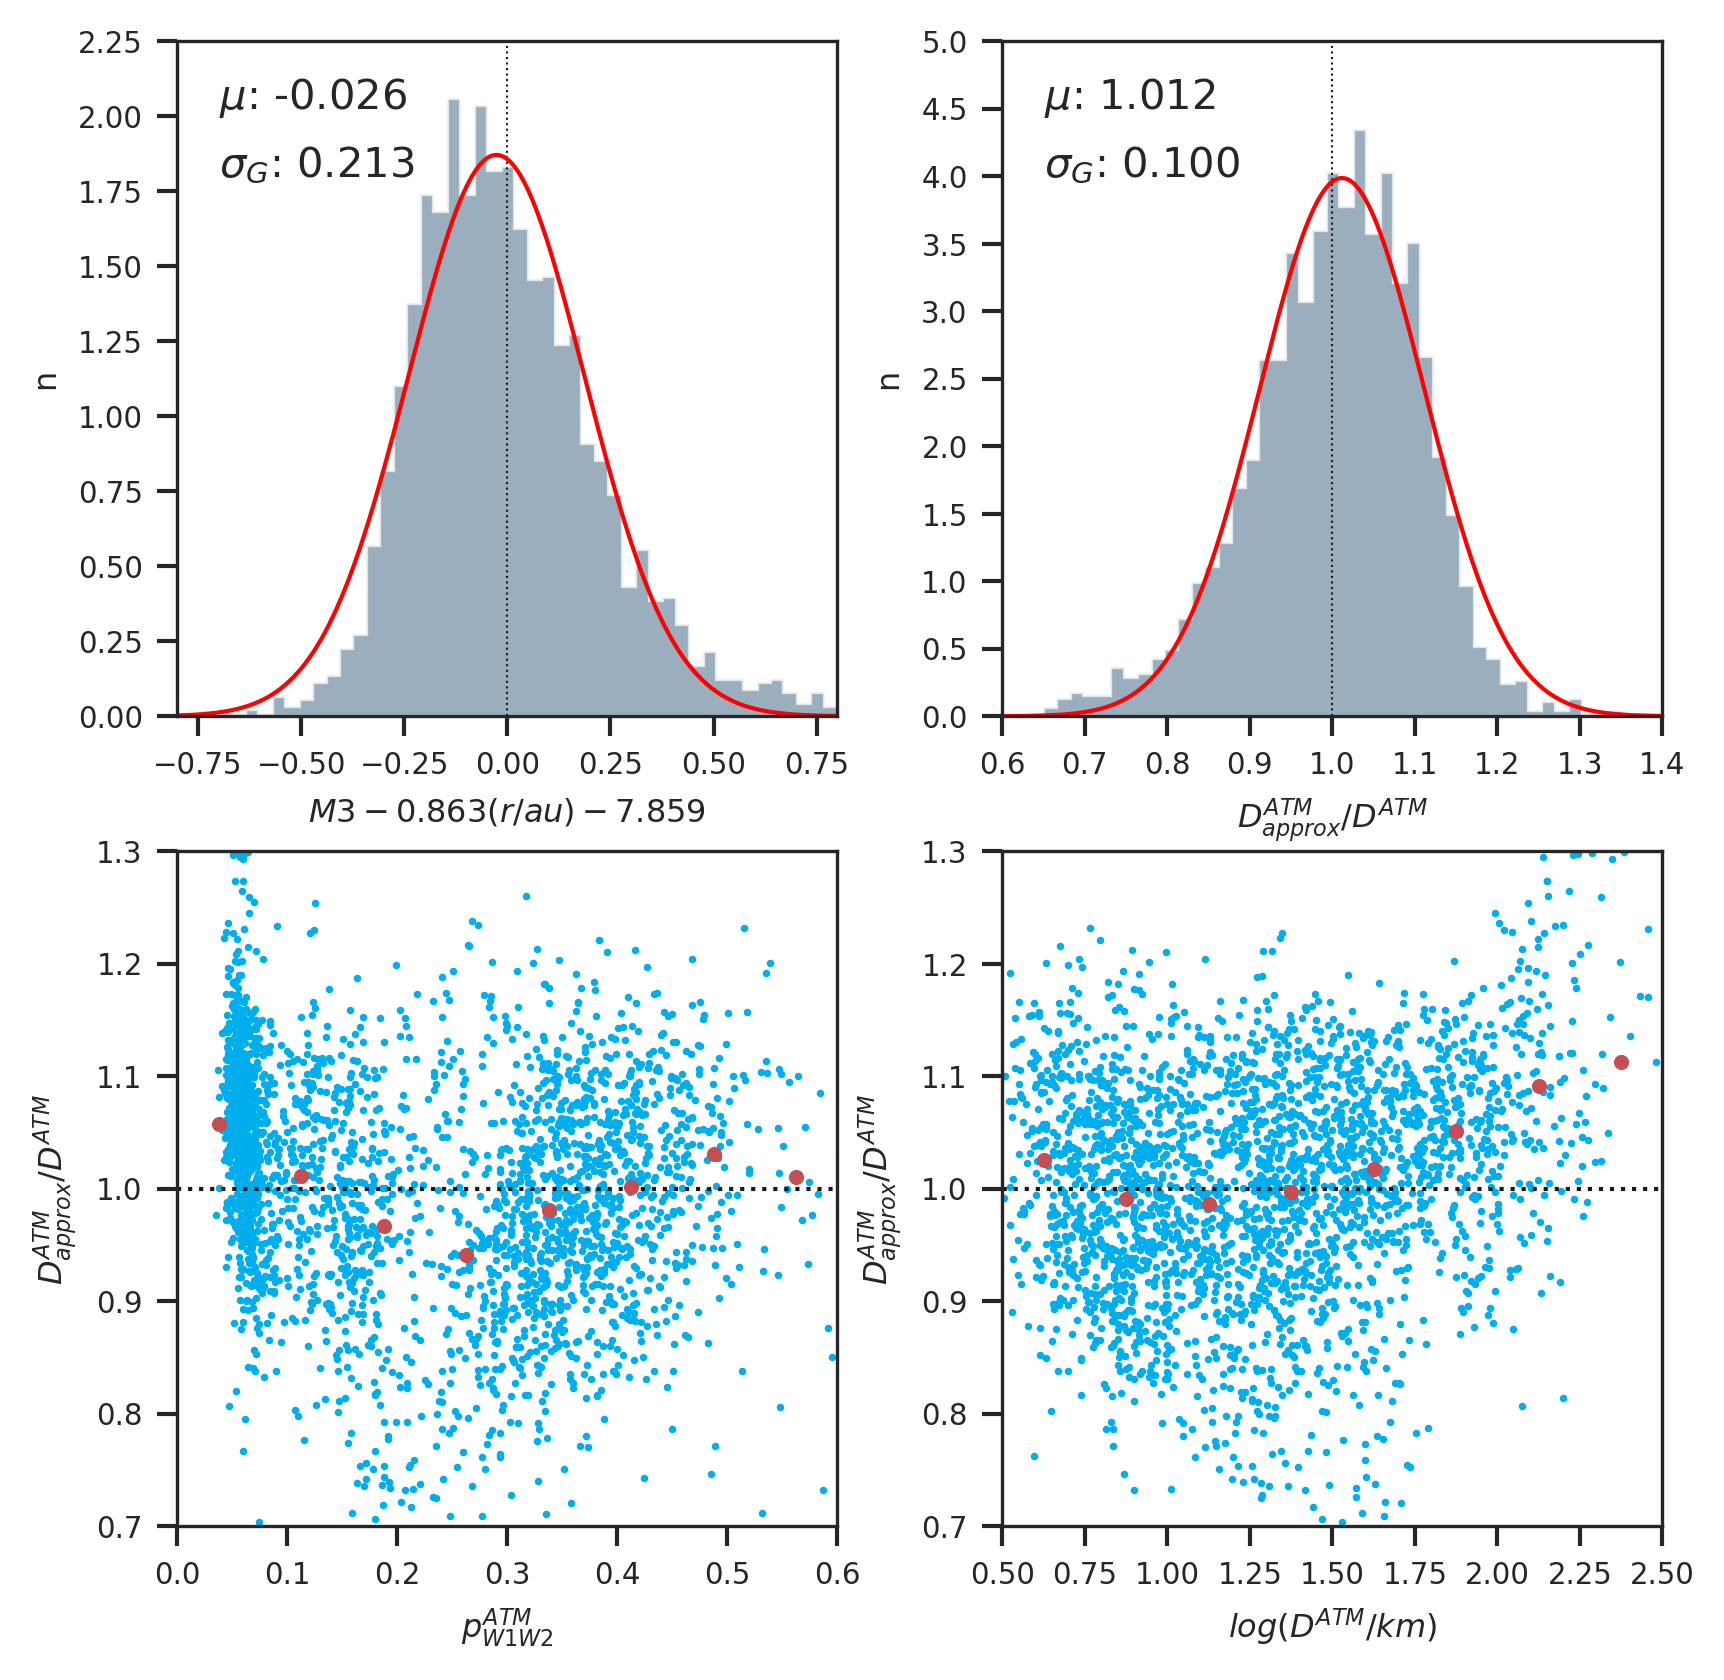

In [13]:
merged_results["eps_W1W2_NEOWISE"] = 1 - merged_results["IR_ALBEDO"] * calcQ(merged_results["SLOPE_PARAM"])
merged_results["p_W1W2_median"] = (1 - merged_results["eps_W1W2_median"]) / calcQ(merged_results["G_median"])

filtered_results = merged_results[(merged_results["num_W1"] >= 4)
                                  & (merged_results["num_W2"] >= 4)
                                  & (merged_results["num_W3"] >= 4)
                                  & (merged_results["num_W4"] >= 4)
                                  & (merged_results["reduced_chi2"] < 3)]
print("Filtered results: {}".format(len(filtered_results)))

histKwargs = {
    "histtype" : "stepfilled",
    "color" : "#718CA1",
    "alpha" : 0.7, 
    "normed" : True,
}

scatterKwargs = {
    "s" : 1,
    "c" : "#00AEEE",
}

horizontalLines = {
    "lw" : 1,
    "linestyle" : ":",
    "zorder" : 1
}


fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   

ax[0,0], stats = plotHist(ax[0,0], 
                          filtered_results["M3"].values - 0.863 * filtered_results["r_au_median"].values -  7.859, 
                          [-0.8, 0.8], 
                          numGauss=1, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs)
ax[0,0].vlines([0.0], 0, 2.25, **verticalLines)
ax[0,0].set_ylabel("n")
ax[0,0].set_xlabel(r"$M3 - 0.863(r/au) - 7.859$")
ax[0,0].set_xlim(-0.8, 0.8)
ax[0,0].set_ylim(0, 2.25)
ax[0,0].text(-0.7, 0.9*2.25, r"$\mu$: {:.3f}".format(stats[0]))
ax[0,0].text(-0.7, 0.8*2.25, r"$\sigma_G$: {:.3f}".format(stats[1]))


ax[0,1], stats = plotHist(ax[0,1], 
                          10**filtered_results["logD_approx_W3"].values / 10**filtered_results["logD_median"].values, 
                          [0.6, 1.4], 
                          numGauss=1, 
                          bins=50,
                          histKwargs=histKwargs,
                          plotKwargs=plotKwargs)
ax[0,1].vlines([1.0], 0, 5, **verticalLines)
ax[0,1].set_ylabel("n")
ax[0,1].set_xlabel(r"$D_{approx}^{ATM} / D^{ATM}$")
ax[0,1].set_xlim(0.6, 1.4)
ax[0,1].set_ylim(0, 5)
ax[0,1].set_xticks(np.arange(0.6, 1.5, 0.1))
ax[0,1].set_yticks(np.arange(0, 5.5, 0.5))
ax[0,1].text(0.65, 0.9*5, r"$\mu$: {:.3f}".format(stats[0]))
ax[0,1].text(0.65, 0.8*5, r"$\sigma_G$: {:.3f}".format(stats[1]))


stats, edges, bin_number = binned_statistic(filtered_results["p_W1W2_median"].values, 
                                            10**filtered_results["logD_approx_W3"].values / 10**filtered_results["logD_median"].values,
                                            statistic="median",
                                            range=[0.0, 0.6],
                                            bins=8)
bin_centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2
ax[1,0].scatter(filtered_results["p_W1W2_median"].values,
                10**filtered_results["logD_approx_W3"].values  / 10**filtered_results["logD_median"].values,
                **scatterKwargs)
ax[1,0].scatter(bin_centers, stats, c="r", s=8, zorder=2)
ax[1,0].hlines([1.0], 0, 7, **horizontalLines)
ax[1,0].set_ylabel(r"$D_{approx}^{ATM} / D^{ATM}$")
ax[1,0].set_xlabel(r"$p_{W1W2}^{ATM}$")
ax[1,0].set_xlim(0.0, 0.6)
ax[1,0].set_ylim(0.7, 1.3)


stats, edges, bin_number = binned_statistic(filtered_results["logD_median"].values - 3, 
                                            10**filtered_results["logD_approx_W3"].values / 10**filtered_results["logD_median"].values,
                                            statistic="median",
                                            range=[0.5, 2.5],
                                            bins=8)
bin_centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2

ax[1,1].scatter(filtered_results["logD_median"].values - 3,
                10**filtered_results["logD_approx_W3"].values  / 10**filtered_results["logD_median"].values,
                **scatterKwargs)
ax[1,1].scatter(bin_centers, stats, c="r", s=8, zorder=2)
ax[1,1].hlines([1.0], 0, 7, **horizontalLines)
ax[1,1].set_ylabel(r"$D_{approx}^{ATM} / D^{ATM}$")
ax[1,1].set_xlabel(r"$log({D^{ATM} / km})$")
ax[1,1].set_xlim(0.5, 2.5)
ax[1,1].set_ylim(0.7, 1.3)
ax[1,1].set_xticks(np.arange(0.5, 2.75, 0.25))
ax[1,1].set_yticks(np.arange(0.7, 1.4, 0.1))


if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "W3_estimator.{}".format(FORMAT)),
            bbox_inches='tight')

In [14]:
con_W3 = sql.connect(os.path.join(ATM_DATA_DIR, "paper1/sample_W3.db"))
observations = pd.read_sql("""SELECT * FROM observations""", con_W3)
neowise = pd.read_sql("""SELECT * FROM neowise_v1""", con_W3)

try:
    observed_stats = pd.read_sql("""SELECT * FROM observed_stats""", con_W3)

except:
    print("Calculating median and sigmaG for W3 observations.")
    print("This may take a while...")
    cols =  observations.columns.to_list()
    cols.remove("obs_id")
    observed_stats =  observations[cols].groupby(by="designation").agg([_median, _sigmaG])
    observed_stats.rename(columns={"_median" : "median", "_sigmaG" : "sigmaG"}, inplace=True)
    observed_stats.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in observed_stats.columns]
    observed_stats.reset_index(inplace=True)
    
    observed_stats.to_sql("observed_stats", con_W3, index=False)
    print("Done.")

In [15]:
p3 = [0.863,  7.859]
logD_est = estimateLogD(observed_stats[["mag_W3_median"]].values,
                        observed_stats["r_au_median"].values,
                        observed_stats["delta_au_median"].values,
                        [p3])
observed_stats["logD_approx_W3"] = logD_est

In [16]:
# Grab only matched objects
neowise = neowise[~neowise["matched_designation"].isna()]

# Grab all DVBI fit codes, grab the ones per object that used the most 
# observations in W3
dvbi = neowise[neowise["FIT_CODE"] == "DVBI"]
dvbi = dvbi.sort_values(by=["matched_designation", "N_W3"], ascending=True)
dvbi.drop_duplicates(subset=["matched_designation"], keep="last", inplace=True)
dvbi = observed_stats.merge(dvbi, left_on="designation", right_on="matched_designation")
assert len(dvbi) == dvbi["matched_designation"].nunique()
print(len(dvbi))

# Grab all DVBI fit codes, grab the ones per object that used the most 
# observations in W3 but also had at least 4 observations in each
# band
dvbi_3obs = neowise[(neowise["FIT_CODE"] == "DVBI") 
                       & (neowise["N_W1"] > 3)
                       & (neowise["N_W2"] > 3)
                       & (neowise["N_W3"] > 3)
                       & (neowise["N_W4"] > 3)]
dvbi_3obs = dvbi_3obs.sort_values(by=["matched_designation", "N_W3"], ascending=True)
dvbi_3obs.drop_duplicates(subset=["matched_designation"], keep="last", inplace=True)
dvbi_3obs = observed_stats.merge(dvbi_3obs, left_on="designation", right_on="matched_designation")
assert len(dvbi_3obs) == dvbi_3obs["matched_designation"].nunique()
print(len(dvbi_3obs))

# Grab all DVB- fit codes, grab the ones per object that used the most 
# observations in W3 but also had at least 4 observations in W3 and W4
dvb_w3w4_3obs = neowise[(neowise["FIT_CODE"] == "DVB-") 
                       & (neowise["N_W3"] > 3)
                       & (neowise["N_W4"] > 3)]
dvb_w3w4_3obs = dvb_w3w4_3obs.sort_values(by=["matched_designation", "N_W3"], ascending=True)
dvb_w3w4_3obs.drop_duplicates(subset=["matched_designation"], keep="last", inplace=True)
dvb_w3w4_3obs = observed_stats.merge(dvb_w3w4_3obs, left_on="designation", right_on="matched_designation")
assert len(dvb_w3w4_3obs) == dvb_w3w4_3obs["matched_designation"].nunique()
print(len(dvb_w3w4_3obs))

# Grab all DV-- fit codes, grab the ones per object that used the most 
# observations in W3 but also had at least 4 observations in W3
dv_w3_3obs = neowise[(neowise["FIT_CODE"] == "DV--") 
                       & (neowise["N_W3"] > 3)]
dv_w3_3obs = dv_w3_3obs.sort_values(by=["matched_designation", "N_W3"], ascending=True)
dv_w3_3obs.drop_duplicates(subset=["matched_designation"], keep="last", inplace=True)
dv_w3_3obs = observed_stats.merge(dv_w3_3obs, left_on="designation", right_on="matched_designation")
assert len(dv_w3_3obs) == dv_w3_3obs["matched_designation"].nunique()
print(len(dv_w3_3obs))

3917
2844
61660
64362


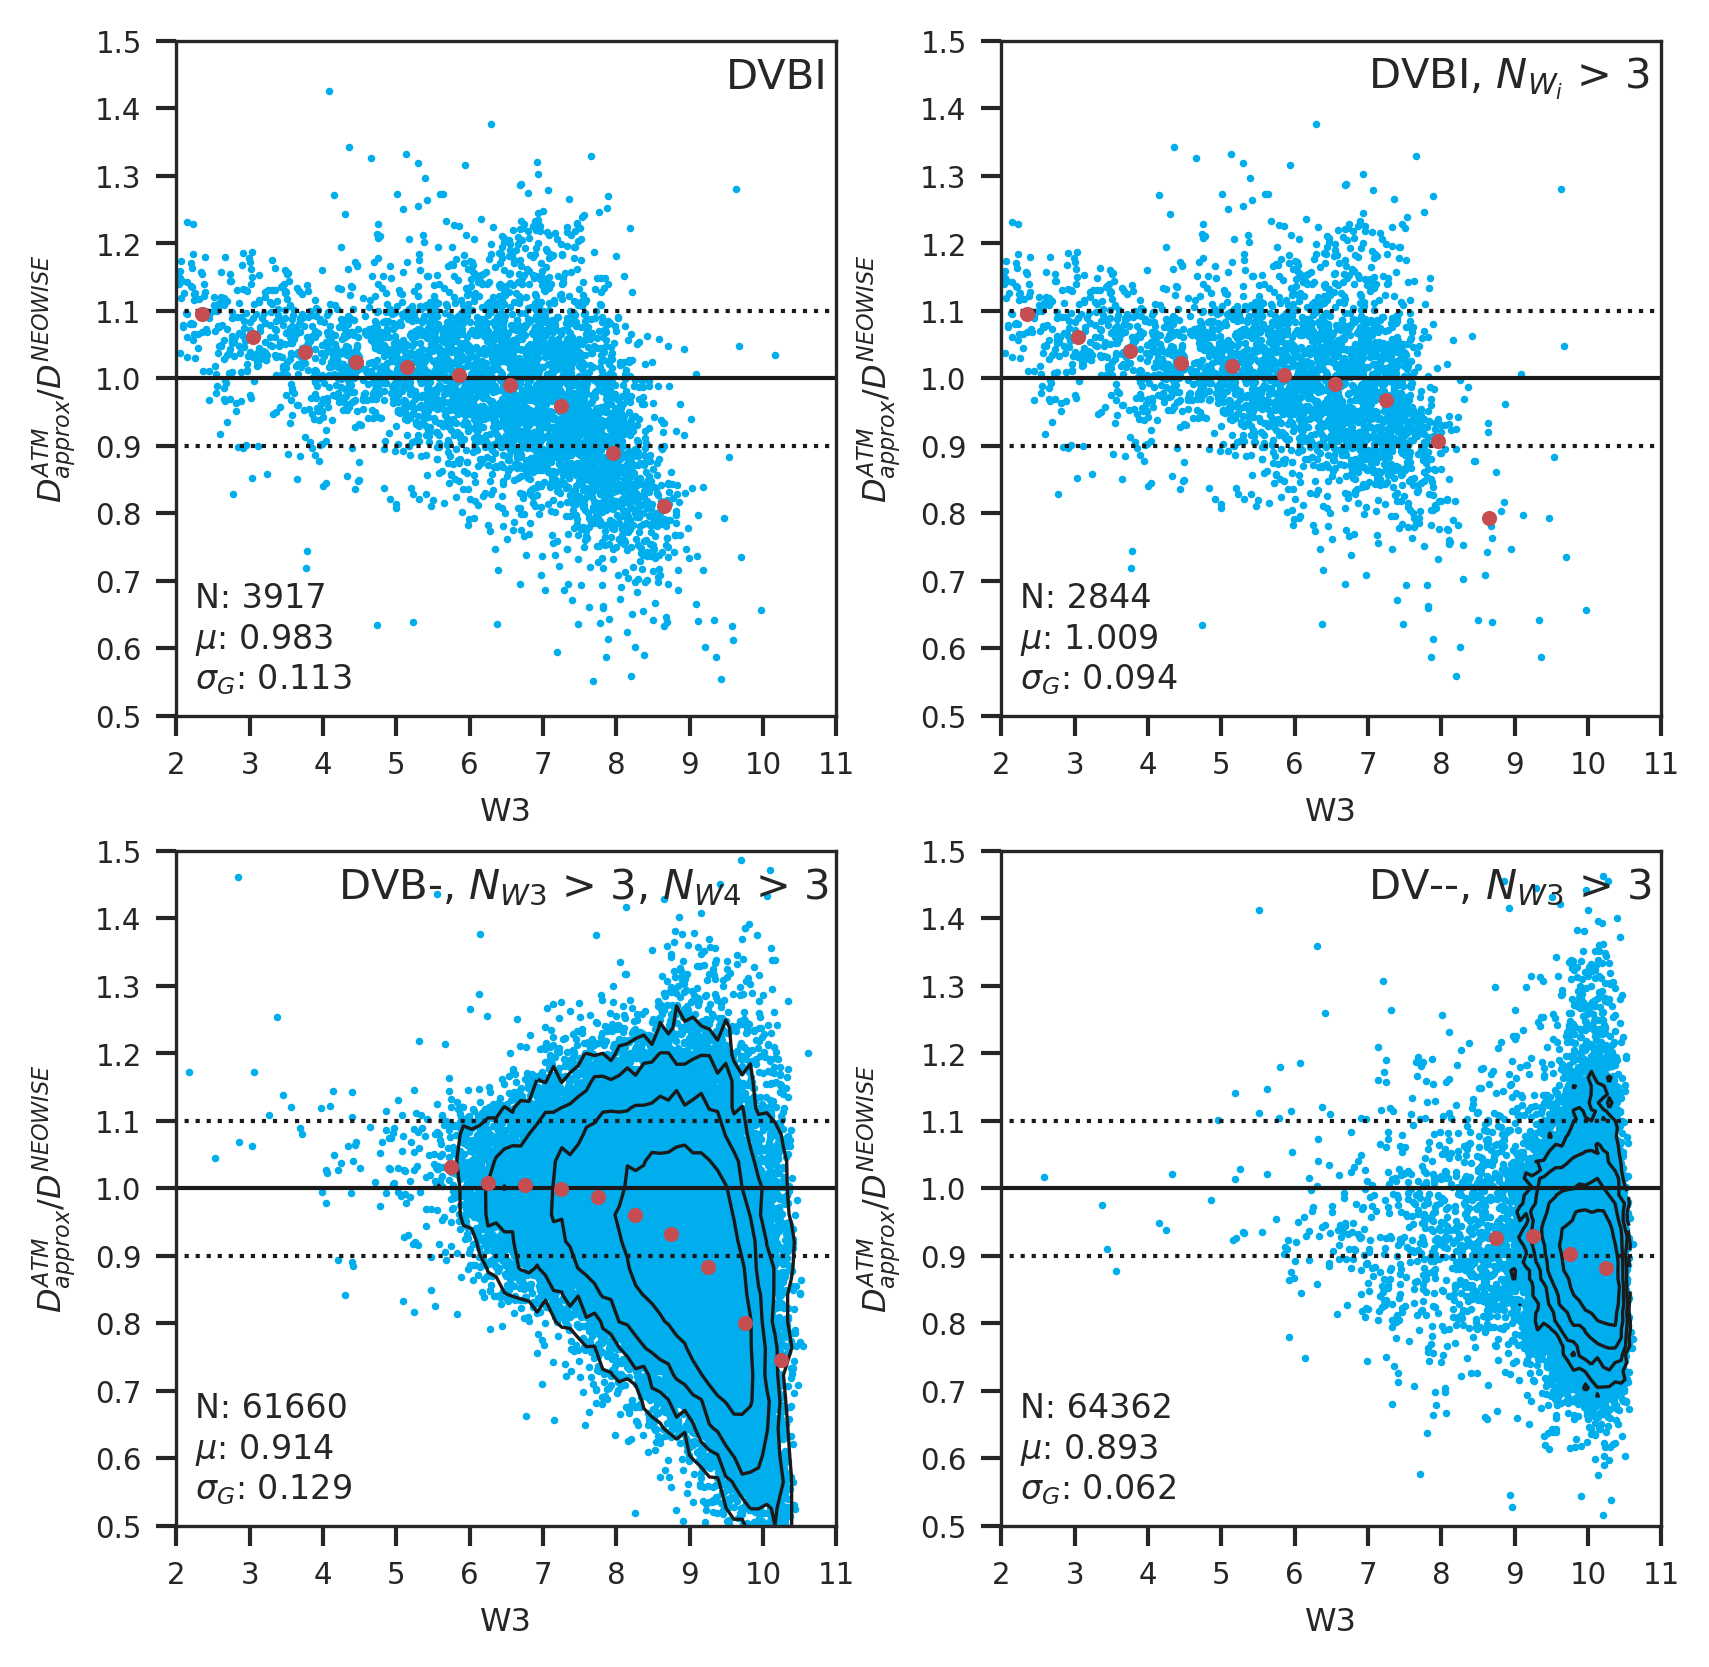

In [17]:
histKwargs = {
    "histtype" : "stepfilled",
    "color" : "b",
    "alpha" : 0.7, 
    "normed" : True,
}

scatterKwargs = {
    "s" : 1,
    "c" : "#00AEEE",
    "alpha" : 1,
}

horizontalLines1 = {
    "lw" : 1,
    "linestyle" : ":",
    "zorder" : 1,
}
horizontalLines2 = {
    "lw" : 1,
    "linestyle" : "-",
    "zorder" : 1,
}

def __helpPlot(ax, N, mu, sigmaG):
    ax.hlines([0.9, 1.1], 0, 11, **horizontalLines1)
    ax.hlines([1.0], 0, 11, **horizontalLines2)
    ax.set_ylabel(r"$D_{approx}^{ATM} / D^{NEOWISE}$")
    ax.set_xlabel(r"W3")
    ax.set_xlim(2, 11)
    ax.set_ylim(0.5, 1.5)
    ax.text(2.25, 0.66, "N: {}".format(N), fontsize=8)
    ax.text(2.25, 0.60, r"$\mu$: {:.3f}".format(mu), fontsize=8)
    ax.text(2.25, 0.54, r"$\sigma_G$: {:.3f}".format(sigmaG), fontsize=8)
    ax.set_xticks(np.arange(2, 12, 1))
    ax.set_yticks(np.arange(0.5, 1.6, 0.1))

fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(5.5, 5.5))
fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.05,  
        # the right side of the subplots of the figure
        right=0.95,
        # the bottom of the subplots of the figure
        bottom=0.05,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.25,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   

# Plot DVBI
filtered_results = dvbi
x = filtered_results["mag_W3_median"].values
y = 10**filtered_results ["logD_approx_W3"].values / (1000 * filtered_results ["DIAMETER"].values)
mu = np.median(y)
sigmaG = calcStdDev(y)
N = len(y)

stats, edges, bin_number = binned_statistic(x, 
                                            y,
                                            statistic="median",
                                            range=[2, 9],
                                            bins=10)
bin_centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2

ax[0,0].scatter(filtered_results ["mag_W3_median"].values, 
                y,
                **scatterKwargs)
ax[0,0].scatter(bin_centers, stats, c="r", s=8, zorder=2)
ax[0,0].text(9.5, 1.43, "DVBI")
__helpPlot(ax[0,0], N, mu, sigmaG)

# Plot DVBI, NW_i > 3
filtered_results = dvbi_3obs
x = filtered_results["mag_W3_median"].values
y = 10**filtered_results ["logD_approx_W3"].values / (1000 * filtered_results ["DIAMETER"].values)
mu = np.median(y)
sigmaG = calcStdDev(y)
N = len(y)

stats, edges, bin_number = binned_statistic(x, 
                                            y,
                                            statistic="median",
                                            range=[2, 9],
                                            bins=10)
bin_centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2

ax[0,1].scatter(filtered_results ["mag_W3_median"].values, 
                y,
                **scatterKwargs)
ax[0,1].scatter(bin_centers, stats, c="r", s=8, zorder=2)
ax[0,1].text(7.0, 1.43, "DVBI, $N_{W_i}$ > 3")
__helpPlot(ax[0,1], N, mu, sigmaG)

# Plot DVB-, NW3 > 3, NW4 > 3
filtered_results = dvb_w3w4_3obs
x = filtered_results["mag_W3_median"].values
y = 10**filtered_results ["logD_approx_W3"].values / (1000 * filtered_results ["DIAMETER"].values)
mu = np.median(y)
sigmaG = calcStdDev(y)
N = len(y)

stats, edges, bin_number = binned_statistic(x, 
                                            y,
                                            statistic="median",
                                            range=[5.5, 10.5],
                                            bins=10)
bin_centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2

stats_2d, xedges, yedges, bin_number_2d = binned_statistic_2d(x, y, x,'count', bins=100)
levels = np.linspace(0, np.log10(stats_2d.max()), 7)[2:]
ax[1,0].contour(np.log10(stats_2d.T), 
                levels, 
                linewidths=0.8,
                colors='k',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax[1,0].scatter(filtered_results ["mag_W3_median"].values, 
                y,
                **scatterKwargs)
ax[1,0].scatter(bin_centers, stats, c="r", s=8, zorder=2)
ax[1,0].text(4.2, 1.43, "DVB-, $N_{W3}$ > 3, $N_{W4}$ > 3")
__helpPlot(ax[1,0], N, mu, sigmaG)

# Plot DV--, NW3 > 3
filtered_results = dv_w3_3obs
x = filtered_results["mag_W3_median"].values
y = 10**filtered_results ["logD_approx_W3"].values / (1000 * filtered_results ["DIAMETER"].values)
mu = np.median(y)
sigmaG = calcStdDev(y)
N = len(y)

stats, edges, bin_number = binned_statistic(x, 
                                            y,
                                            statistic="median",
                                            range=[8.5, 10.5],
                                            bins=4)
bin_centers = edges[:-1] + (edges[1:] - edges[:-1]) / 2

stats_2d, xedges, yedges, bin_number_2d = binned_statistic_2d(x, y, x,'count', bins=100)
levels = np.linspace(0, np.log10(stats_2d.max()), 7)[2:]
ax[1,1].contour(np.log10(stats_2d.T), 
                levels, 
                linewidths=0.8,
                colors='k',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax[1,1].scatter(filtered_results ["mag_W3_median"].values, 
                y,
                **scatterKwargs)
ax[1,1].scatter(bin_centers, stats, c="r", s=8, zorder=2)
ax[1,1].text(7.0, 1.43, "DV--, $N_{W3}$ > 3")
__helpPlot(ax[1,1], N, mu, sigmaG)

if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "W3_estimator_codes.{}".format(FORMAT)),
            bbox_inches='tight')